# Alzheimer's disease Classification

In this notebook, I will fit the models for Alzheimer's classification. I have three levels of disease Very Mild, Mild, and Moderate. They all have different numbers of images for training - imbalanced classes. My No Disease class has the most images and Modelate disease has very few images. My baseline is 50%. [Study](https://www.medscape.com/viewarticle/883192) showed that Alzheimer's disease classification accuracy from MRI scans is around 75%. In this notebook I will build a CNN model and use pre-trained models - EfficientNetV2S, Xception, and Resnet50.

In [4]:
# Imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2S, Xception, resnet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import functions

import numpy as np
np.random.seed(18)

In [3]:
# The path to the training and testing sets
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Set image size
image_size = 240

# Set optimizer
learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## CNN model

In [4]:
# Load data fror training
al_train_ds, al_val_ds = image_dataset_from_directory(
    al_path_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',  # The images are black and wight
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18,
    validation_split=0.2,
    subset = 'both'
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Using 1024 files for validation.


In [5]:
# Load data for Testing
al_test_ds = image_dataset_from_directory(
    al_path_test,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',  # The images are black and wight
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18
)

Found 1279 files belonging to 4 classes.


In [7]:
model = Sequential()

model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Third Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Fourth Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_ds, validation_data = al_val_ds, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 220s 3s/step - loss: 1.1269 - accuracy: 0.4686 - val_loss: 1.1744 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 225s 3s/step - loss: 1.0746 - accuracy: 0.4794 - val_loss: 1.1508 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 223s 3s/step - loss: 1.0607 - accuracy: 0.4838 - val_loss: 1.0133 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 222s 3s/step - loss: 1.0129 - accuracy: 0.5172 - val_loss: 0.9399 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 216s 3s/step - loss: 0.9491 - accuracy: 0.5502 - val_loss: 0.9561 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 180s 3s/step - loss: 0.9156 - accuracy: 0.5763 - val_loss: 0.8986 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 135s 2s/step - loss: 0.9

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 119, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                    

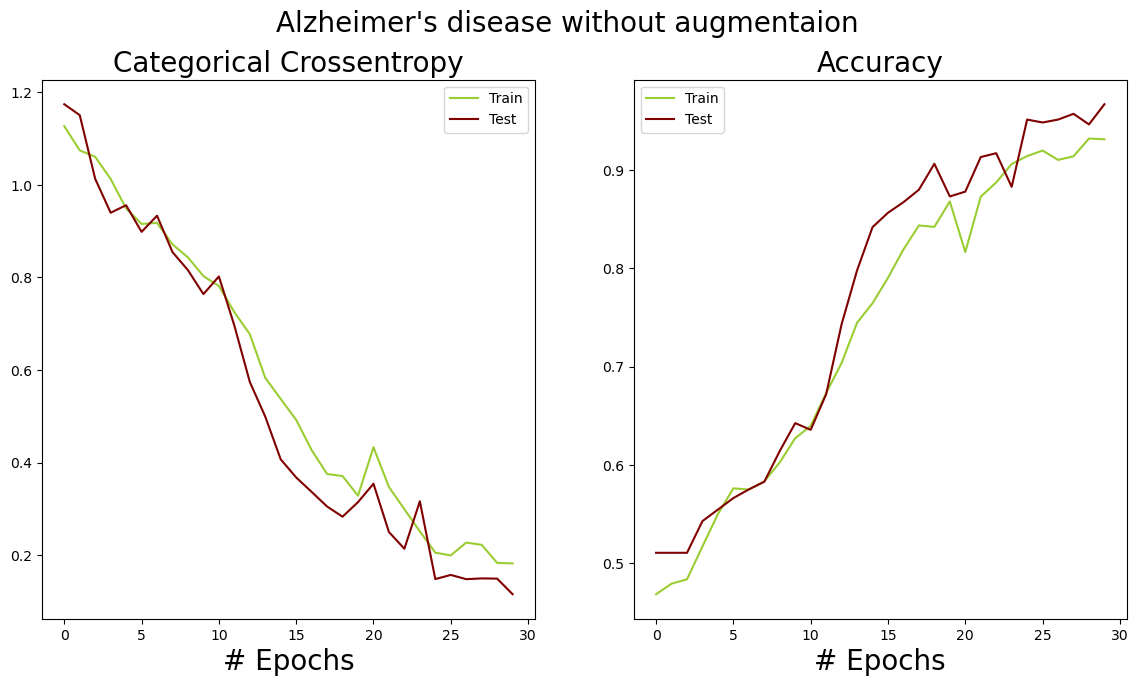

In [10]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Alzheimer\'s disease without augmentaion')

Accuracy_score: 0.9668 



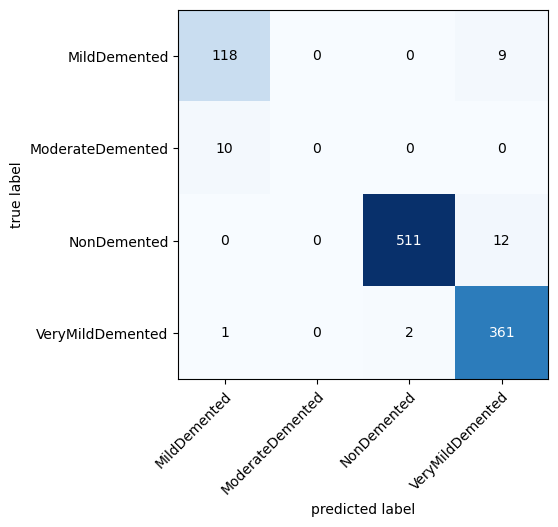

In [9]:
# Plot Confusion Matrix for Validation set
functions.acc_conf_matrix(model, val_data=al_val_ds)

Accuracy_score: 0.6747 



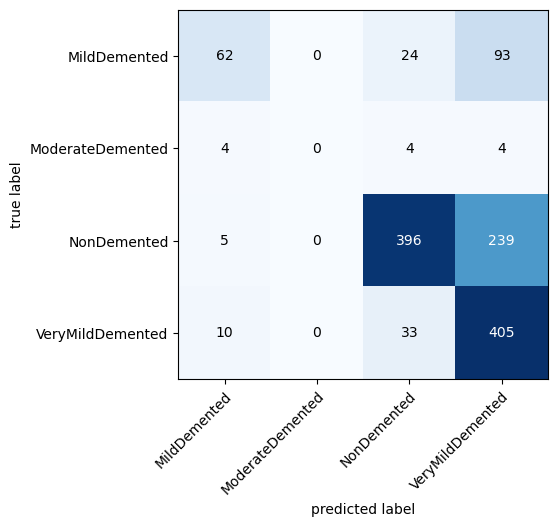

In [8]:
# Plot Confusion Matrix for Testing data
functions.acc_conf_matrix(model, val_data=al_test_ds)

The model performs well on the validating set, except Moderate Alzheimer's. The model does not perform great on the test set, it is overfit. I have tried different Dropouts, learning rate and regularizations and this is my best model. The worst predicted is Modetate Demented. 

---

# Pre-trained models

Pre-trained models requare color images I will have to read the images separately and convert each to RGB. Inspired by https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

In [11]:
# Read the images, convert to grayscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val = functions.read_gray_images_to_rgb(al_path_train)

# Check the shape of the data
X_train.shape, y_train.shape

((3840, 240, 240, 3), (3840, 4))

In [12]:
# Prepare the training data for predictions
X_test, y_test = functions.read_gray_images_to_rgb(al_path_test, train_test = False)

# Check the shape of the data
X_test.shape, y_test.shape

((1279, 240, 240, 3), (1279, 4))

Another option for grayscale images is to read them as RGB

In [3]:
# Load data fror training
al_train_ds_rgb, al_val_ds_rgb = image_dataset_from_directory(
    al_path_train,
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18,
    validation_split=0.2,
    subset = 'both'
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Using 1024 files for validation.


In [4]:
# Load data for Testing
al_test_ds_rgb = image_dataset_from_directory(
    al_path_test,
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18
)

Found 1279 files belonging to 4 classes.


---

## EfficientNetV2S

In [61]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [62]:
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [18]:
# Read images as RGB to use in pre-trained model

model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 402s 6s/step - loss: 0.9356 - accuracy: 0.5724 - val_loss: 0.8420 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 365s 6s/step - loss: 0.8128 - accuracy: 0.6270 - val_loss: 0.8198 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 358s 6s/step - loss: 0.7747 - accuracy: 0.6468 - val_loss: 0.7413 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 359s 6s/step - loss: 0.7358 - accuracy: 0.6739 - val_loss: 0.7123 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 361s 6s/step - loss: 0.7106 - accuracy: 0.6749 - val_loss: 0.7445 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 368s 6s/step - loss: 0.6825 - accuracy: 0.6961 - val_loss: 0.7542 - val_accuracy: 0.6465 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 358s 6s/step - loss: 0.6

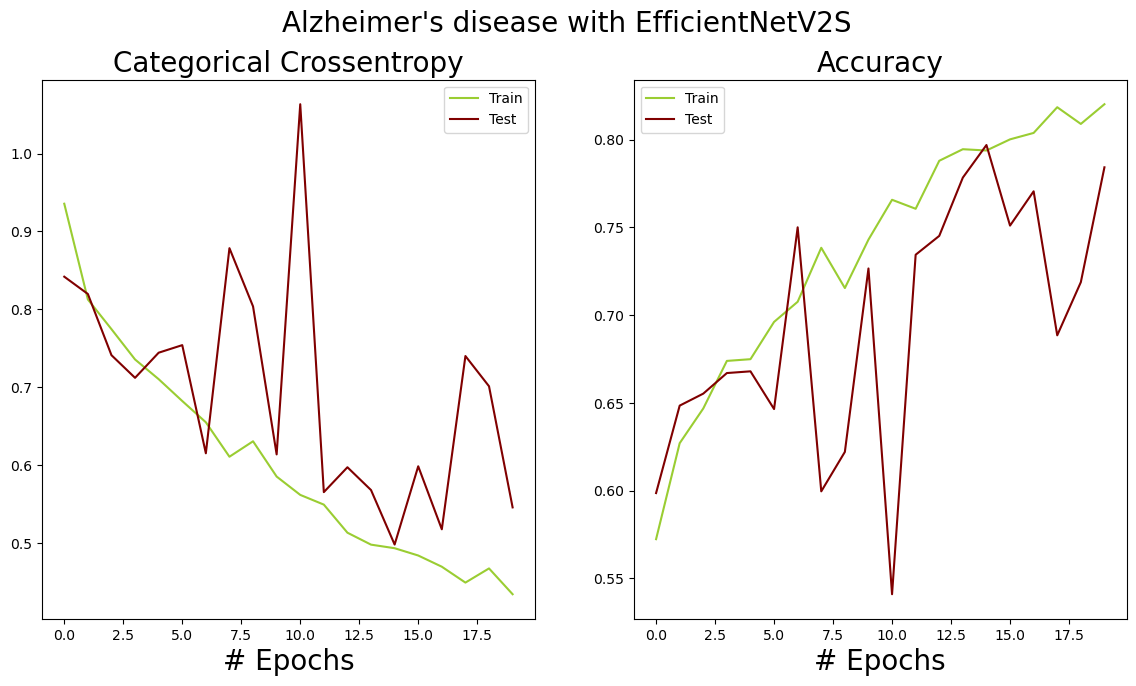

In [19]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Alzheimer\'s disease with EfficientNetV2S')

Accuracy_score: 0.7969 



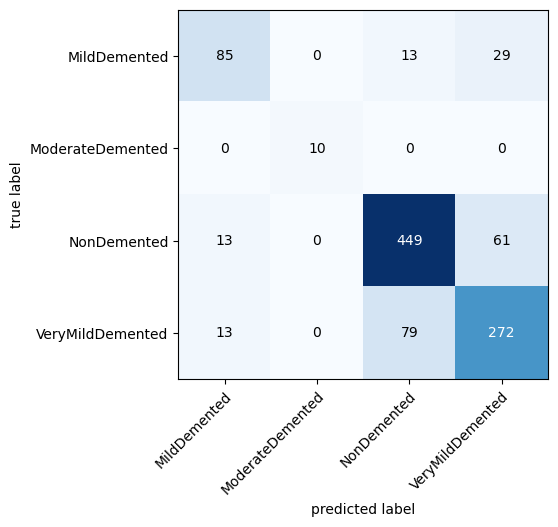

In [20]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_val_ds_rgb)

Accuracy_score: 0.6349 



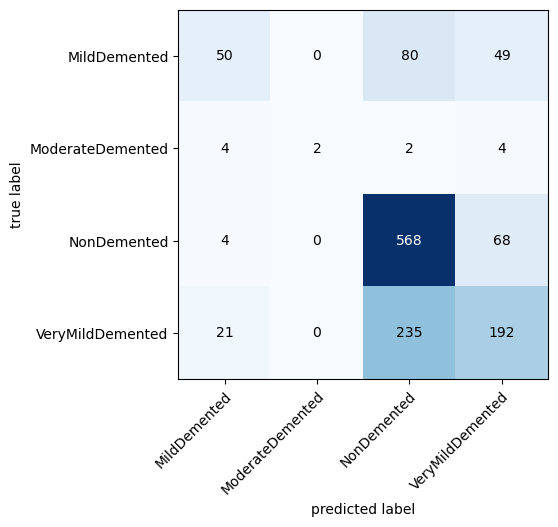

In [23]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_test_ds_rgb)

The accuracy on the training set is lower, than for my CNN

In [63]:
# Read images and convert each to RGB
model = Sequential()
model.add(effnet)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 416s 3s/step - loss: 0.9536 - accuracy: 0.5695 - val_loss: 0.8548 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 408s 3s/step - loss: 0.8052 - accuracy: 0.6352 - val_loss: 0.7559 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 407s 3s/step - loss: 0.7465 - accuracy: 0.6654 - val_loss: 0.7160 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 422s 4s/step - loss: 0.7101 - accuracy: 0.6849 - val_loss: 0.6830 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 391s 3s/step - loss: 0.6611 - accuracy: 0.7156 - val_loss: 0.6910 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 288s 2s/step - loss: 0.6476 - accuracy: 0.7177 - val_loss: 0.6934 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 356s 3s/st

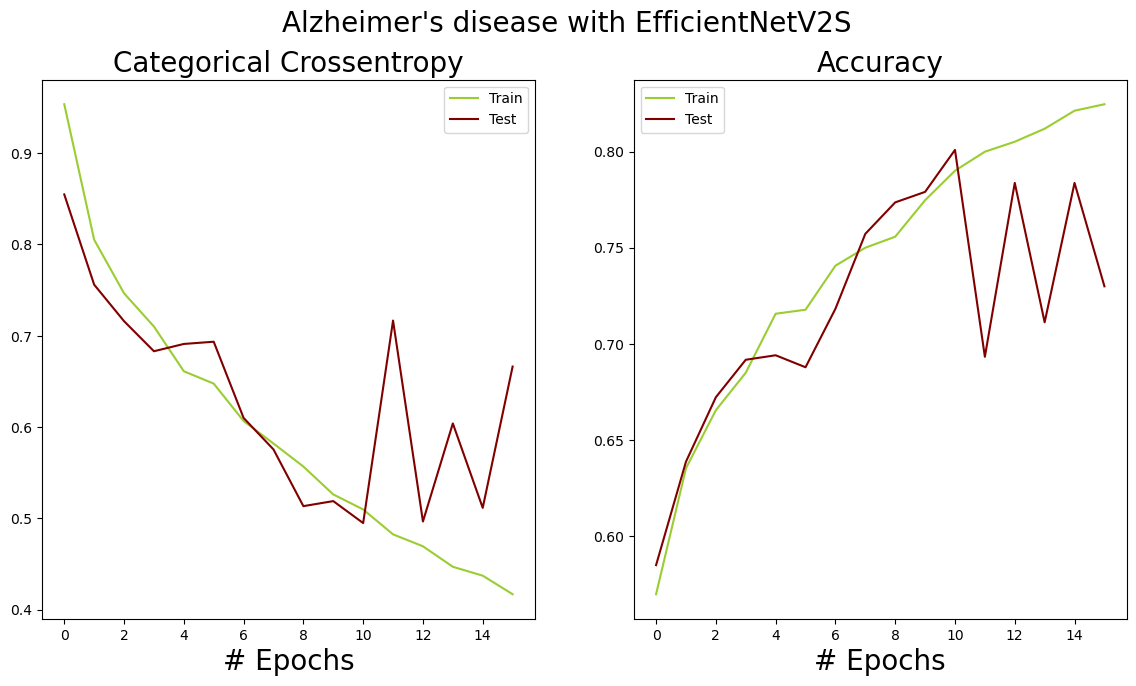

In [64]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Alzheimer\'s disease with EfficientNetV2S')

Accuracy_score: 0.8009 



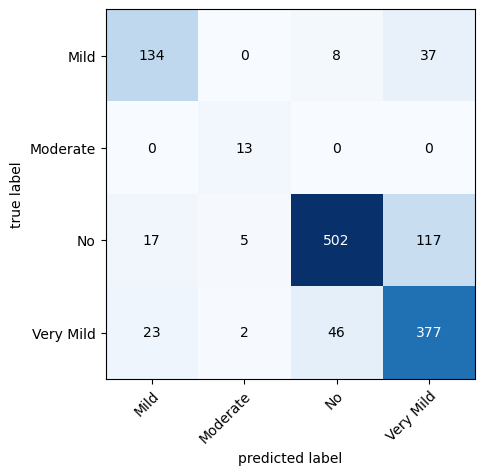

In [65]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6458 



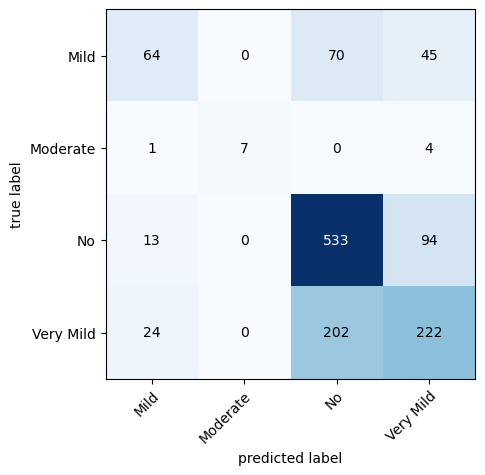

In [66]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

EfficientNetV2S with images separately and convert each to RGB have accuracy higher than read as RBG, but lolwer than CNN model

---

## Xception

In [53]:
xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [54]:
# Freeze last 5 layers
for layer in xception_model.layers[:-5]:
    layer.trainable = False

In [26]:
# Read images as RGB to use in pre-trained model

model = Sequential()

model.add(xception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))
#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_xc = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 223s 3s/step - loss: 0.8862 - accuracy: 0.5870 - val_loss: 1.7506 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 219s 3s/step - loss: 0.7860 - accuracy: 0.6441 - val_loss: 1.1924 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 228s 4s/step - loss: 0.7136 - accuracy: 0.6868 - val_loss: 0.8057 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 226s 3s/step - loss: 0.6380 - accuracy: 0.7332 - val_loss: 0.8522 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 189s 3s/step - loss: 0.5466 - accuracy: 0.7725 - val_loss: 1.3854 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 187s 3s/step - loss: 0.5295 - accuracy: 0.7884 - val_loss: 0.9522 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 188s 3s/step - loss: 0.4

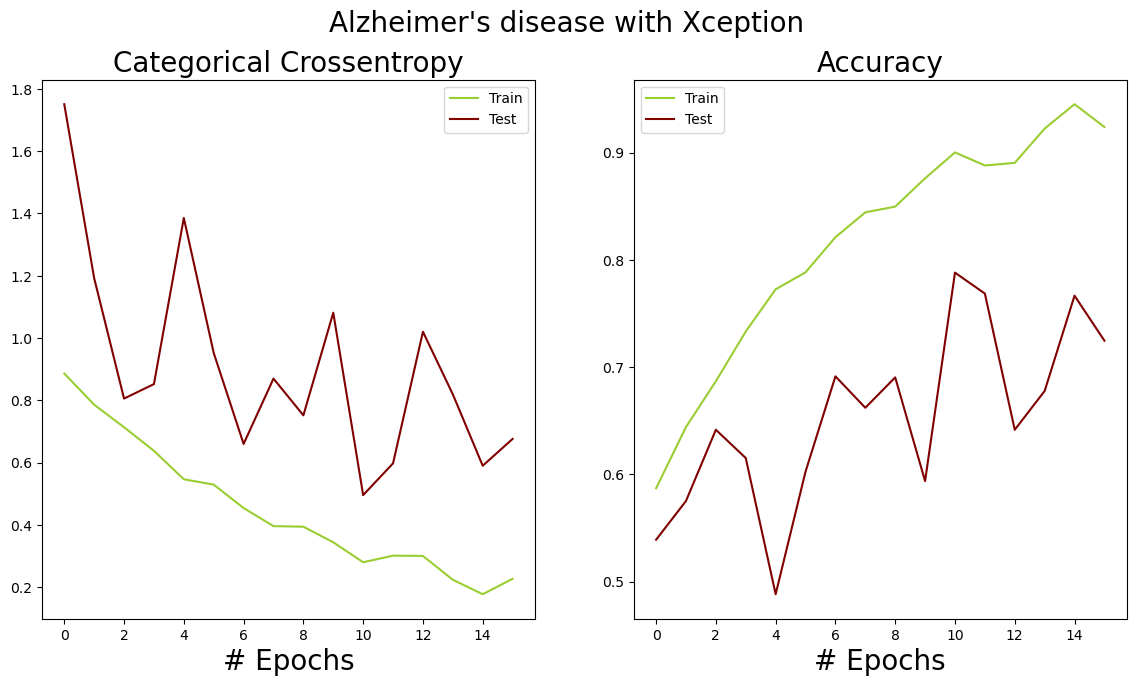

In [27]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_xc, 'Alzheimer\'s disease with Xception')

Accuracy_score: 0.7881 



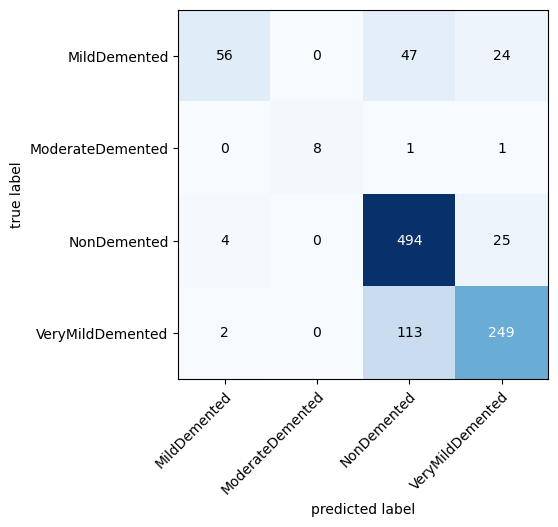

In [28]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_val_ds_rgb)

Accuracy_score: 0.5919 



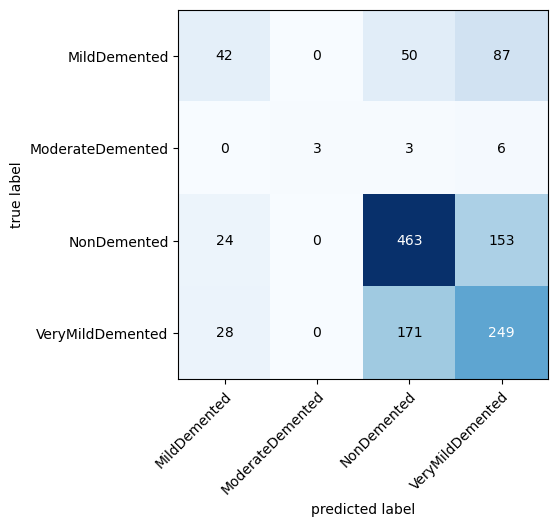

In [29]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_test_ds_rgb)

Xception with images read as RGB have accuracy lower than my CNN model

In [56]:
# Read images and convert each to RGB
model = Sequential()
model.add(xception_model)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_xc = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 561s 4s/step - loss: 0.8910 - accuracy: 0.5820 - val_loss: 1.2167 - val_accuracy: 0.5839 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 412s 3s/step - loss: 0.7567 - accuracy: 0.6602 - val_loss: 1.0527 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 365s 3s/step - loss: 0.6554 - accuracy: 0.7115 - val_loss: 0.9665 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 380s 3s/step - loss: 0.5616 - accuracy: 0.7628 - val_loss: 0.9122 - val_accuracy: 0.6315 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 364s 3s/step - loss: 0.4437 - accuracy: 0.8203 - val_loss: 0.8065 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 380s 3s/step - loss: 0.3793 - accuracy: 0.8513 - val_loss: 0.6742 - val_accuracy: 0.7166 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 297s 2s/st

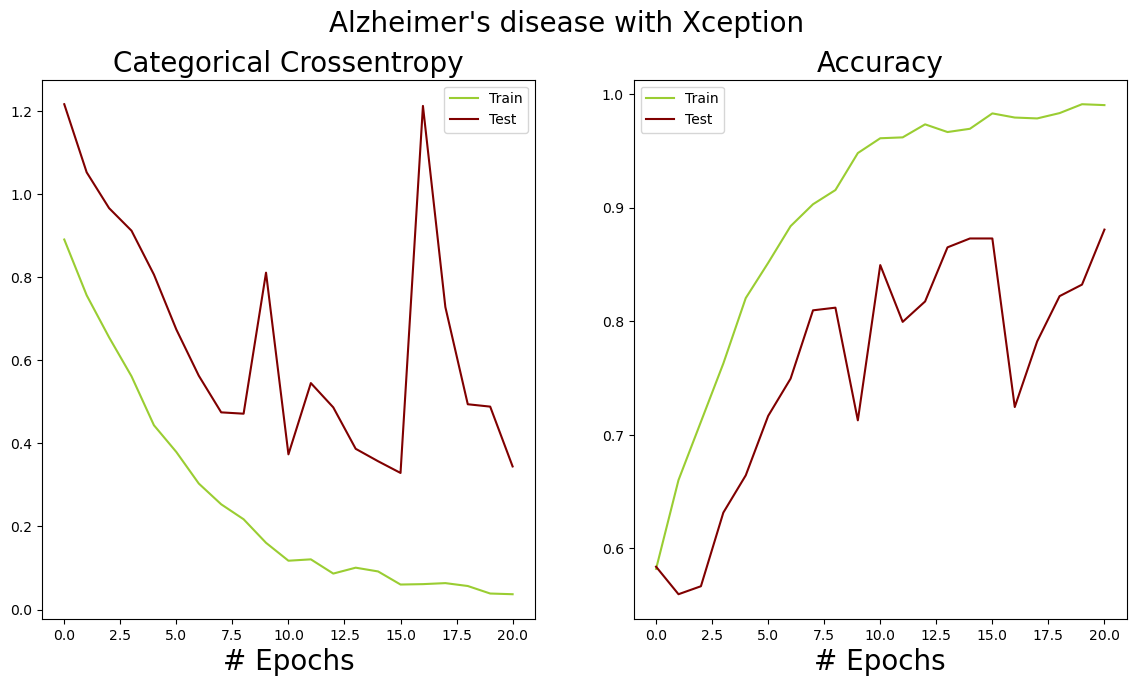

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_xc, 'Alzheimer\'s disease with Xception')

Accuracy_score: 0.8728 



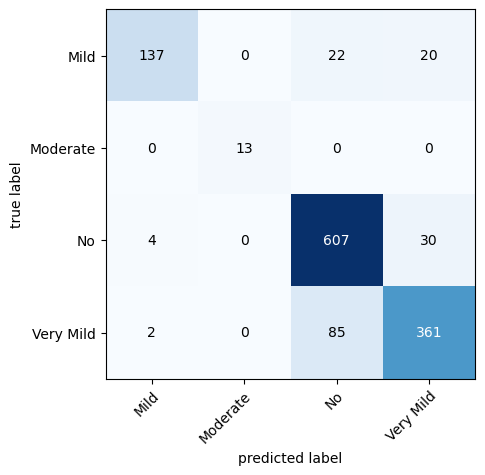

In [59]:
# Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

This model struggles to classify Very Mild Alzheimer.

Accuracy_score: 0.5942 



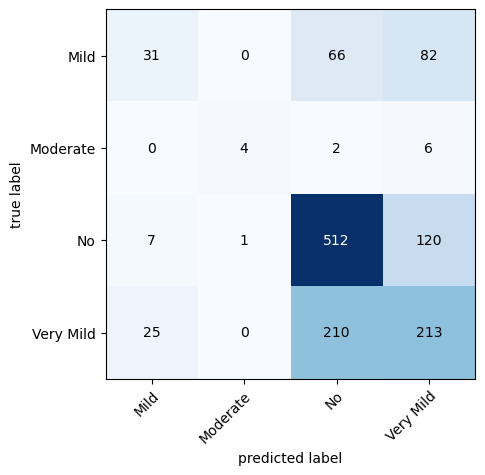

In [60]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Xception with images transformed to RBG has a bit higher accuracy than read as RGB, however, Xception models have the lowest accuracy of all models I have tried.

### ResNet50

In [28]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [29]:
for layer in rn_model.layers:
    layer.trainable = False

In [12]:
# Read images as RGB to use in pre-trained model - my best model for this notebook
model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 163s 2s/step - loss: 11.6089 - accuracy: 0.5538 - val_loss: 3.0100 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 158s 2s/step - loss: 0.7866 - accuracy: 0.8435 - val_loss: 0.5583 - val_accuracy: 0.8184 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 160s 2s/step - loss: 0.1286 - accuracy: 0.9578 - val_loss: 0.3870 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 161s 2s/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.2371 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 214s 3s/step - loss: 0.0081 - accuracy: 0.9998 - val_loss: 0.2078 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 216s 3s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1868 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 227s 3s/step - loss: 0.

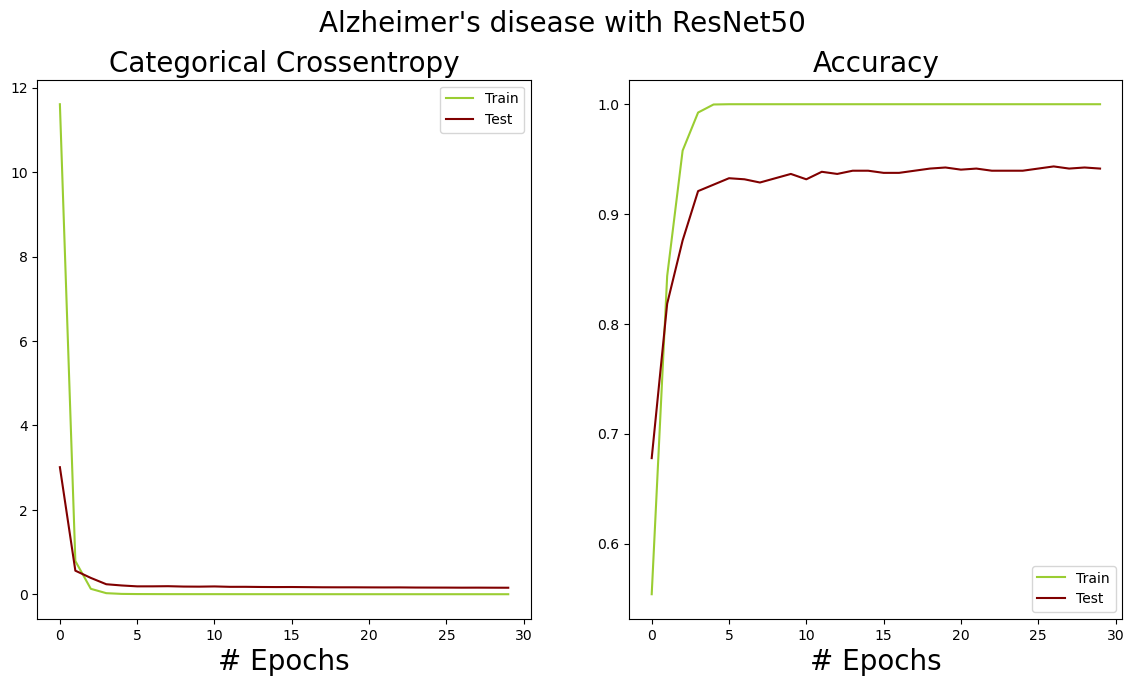

In [15]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with ResNet50')

Accuracy_score: 0.9414 



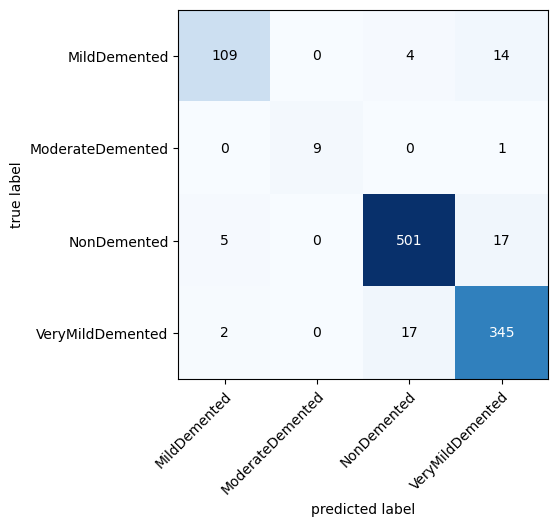

In [16]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_val_ds_rgb)

Accuracy_score: 0.6857 



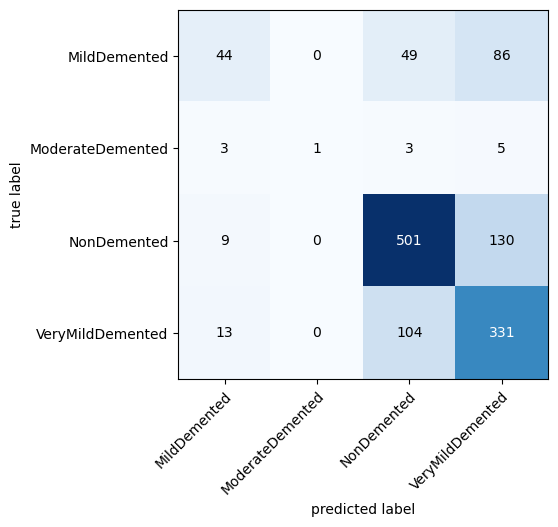

In [14]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_test_ds_rgb)

This is my best model so far. The accuracy is still very low and it is overfit.

In [35]:
# Read the images, convert to grayscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val = read_gray_images_to_rgb(al_path_train)

# Check the shape of the data
X_train.shape, y_train.shape

((3840, 240, 240, 3), (3840, 4))

In [38]:
# Prepare the training data for predictions
X_test, y_test = read_gray_images_to_rgb(al_path_test, train_test = False)

# Check the shape of the data
X_test.shape, y_test.shape

((1279, 240, 240, 3), (1279, 4))

In [36]:
# Read images and convert each to RGB
model = Sequential()
model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 180s 1s/step - loss: 5.7574 - accuracy: 0.6151 - val_loss: 1.6532 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 173s 1s/step - loss: 0.7794 - accuracy: 0.8427 - val_loss: 1.0654 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 175s 1s/step - loss: 1.4284 - accuracy: 0.8104 - val_loss: 2.3053 - val_accuracy: 0.7463 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 172s 1s/step - loss: 0.6846 - accuracy: 0.9068 - val_loss: 1.6233 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 177s 1s/step - loss: 0.2468 - accuracy: 0.9557 - val_loss: 0.7426 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 224s 2s/step - loss: 0.1548 - accuracy: 0.9706 - val_loss: 0.5979 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 251s 2s/st

Accuracy_score: 0.6747 



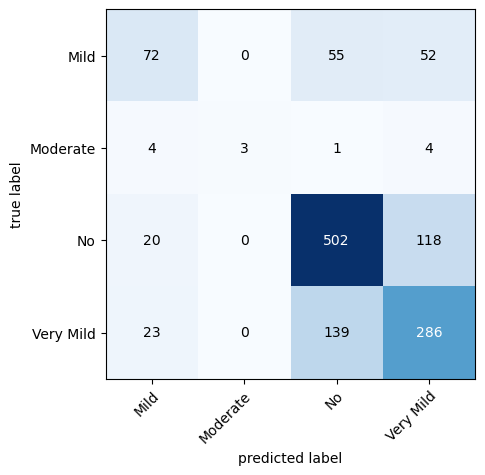

In [39]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

The model with images and converted to RGB have lower accuracy than the one with images read as RGB

## Apply class weigths
My data is extremely imbalanced and I will try to combat it by applying class weights. Inspired by https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [45]:
# Read the images, convert to grayscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val, class_weights = functions.read_gray_images_to_rgb(al_path_train, weights = True)

In [48]:
# Read images and convert each to RGB
model = Sequential()
model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), class_weight=weights_dict, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 273s 2s/step - loss: 13.6334 - accuracy: 0.4734 - val_loss: 8.0728 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 263s 2s/step - loss: 1.6801 - accuracy: 0.7737 - val_loss: 2.2024 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 259s 2s/step - loss: 1.3064 - accuracy: 0.8135 - val_loss: 1.6086 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 257s 2s/step - loss: 0.3861 - accuracy: 0.8893 - val_loss: 1.2365 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 259s 2s/step - loss: 0.1230 - accuracy: 0.9526 - val_loss: 0.7371 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 254s 2s/step - loss: 0.0489 - accuracy: 0.9810 - val_loss: 1.0080 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 205s 2s/s

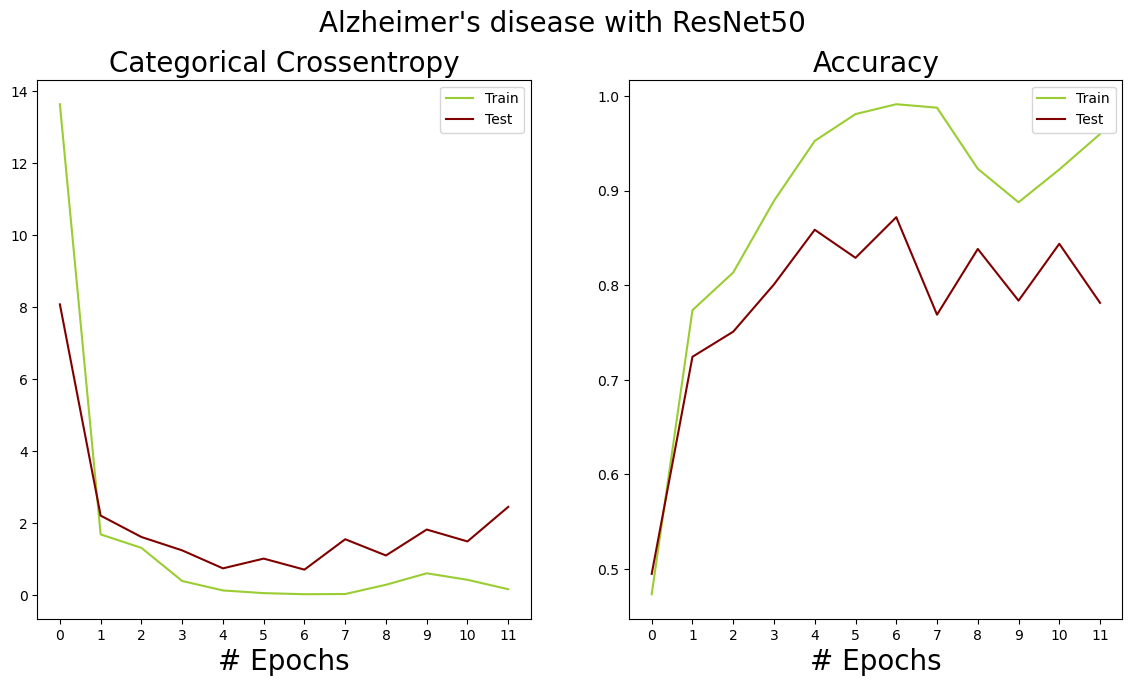

In [50]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with ResNet50')

Accuracy_score: 0.872 



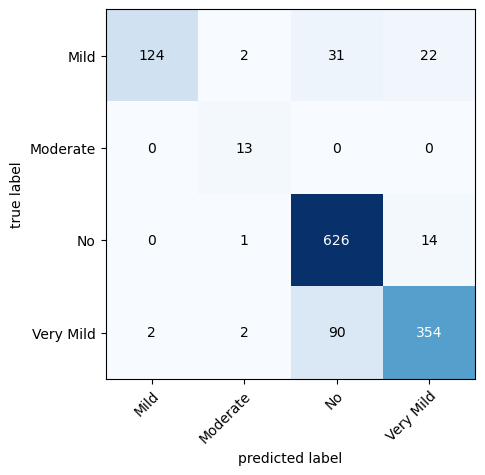

In [51]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6403 



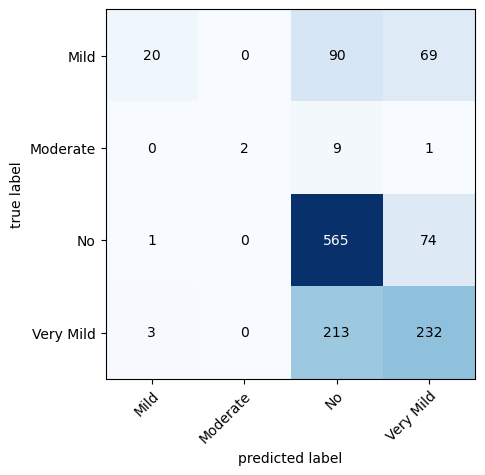

In [49]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

The model accuracy got from 67% to 64%. Adding weights did not improve my model.

---

The ResNet50 is my best model so far with about 69% accuracy. My validation accuracy (set used in training the model) is much higher. I will need to combat overfitting. Xception performed the worse on this data. Adding weights did not improve model accuracy.
In the next notebook, I will use the same models on Brain Tumor data.